In [1]:
import scipy.io
import numpy as np

from torch.utils.data import DataLoader
import deepclean_prod as dc
import torch
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt

# Loading & Formatting the data

In [2]:
time = 1381528818
train_data = np.load('data/train_{}.npy'.format(time))
val_data = np.load('data/val_{}.npy'.format(time))
test_data = np.load('data/test_{}.npy'.format(time))

In [3]:
train_data.shape

(10, 7200)

# Training

Everything here is strongly influenced/ copied from the DeepClean setup as documented [here](https://git.ligo.org/tri.nguyen/deepclean-prod/-/tree/master?ref_type=heads)

In [4]:
class TimeSeriesSegmentDataset(Dataset):

    def __init__(self, data, kernel, stride, fs, pad_mode='median', target_idx=0):

        super().__init__()

        self.kernel = kernel
        self.stride = stride
        self.fs = fs
        self.pad_mode = pad_mode
        self.data = data
        self.target_idx = target_idx

    def __len__(self):
        """ Return the number of stride """
        nsamp = self.data.shape[-1]
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        n_stride = int(np.ceil((nsamp - kernel) / stride) + 1)
        return max(0, n_stride)

    def __getitem__(self, idx):
        """ Get sample Tensor for a given index """
        # check if idx is valid:
        if idx < 0:
            idx +=  self.__len__()
        if idx >= self.__len__():
            raise IndexError(
                f'index {idx} is out of bound with size {self.__len__()}.')

        # get sample
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        idx_start = idx * stride
        idx_stop = idx_start + kernel
        data = self.data[:, idx_start: idx_stop].copy()

        # apply padding if needed
        nsamp = data.shape[-1]
        if nsamp < kernel:
            pad = kernel - nsamp
            data = np.pad(data, ((0, 0), (0, pad)), mode=self.pad_mode)

        # separate into target strain and witnesses
        target = data[self.target_idx]
        aux = np.delete(data, self.target_idx, axis=0)

        # convert into Tensor
        target = torch.Tensor(target)
        aux = torch.Tensor(aux)

        return aux, target

In [5]:
train = TimeSeriesSegmentDataset(train_data, 60.0, 1.0, 4, target_idx=9)
train_loader = DataLoader(train, 32, num_workers=4)
valid = TimeSeriesSegmentDataset(val_data, 60.0, 1.0, 4, target_idx=9)
val_loader = DataLoader(valid, 32, num_workers=4)
test = TimeSeriesSegmentDataset(test_data, 60.0, 1.0, 4, target_idx=9)
test_loader = DataLoader(test, 32, num_workers=4)

In [6]:
# load model (DeepClean)
print(train_data.shape[0]-1)
model = dc.nn.net.DeepClean(9)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)
model = model.to(device)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=1, threshold= 0.001)

criterion = torch.nn.MSELoss(reduction='mean')

9
cuda


In [7]:
# Actually start the training
train_logger = dc.logger.Logger(outdir='training/deepclean/.', metrics=['loss'])
dc.nn.utils.train(
    train_loader, model, criterion, optimizer, lr_scheduler,
    val_loader=val_loader, max_epochs=200, logger=train_logger,
    device=device)

## Plotting training progress

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
loss = np.loadtxt('training/deepclean/metrics/loss.dat', skiprows=1, delimiter=',')
epochs = loss[:,1]
train_loss = loss[:,2]
valid_loss = loss[:,3]

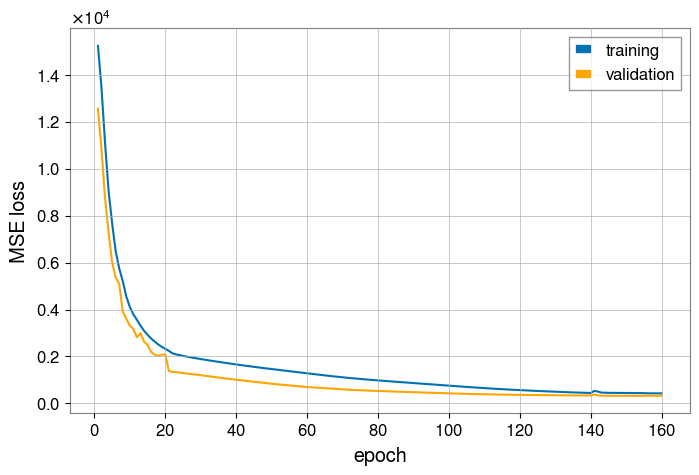

In [10]:
plt.plot(epochs, train_loss, label='training')
plt.plot(epochs, valid_loss, c='orange', label='validation')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Inference

test how well the model has actually learnt to predict `L1:ISI-HAM5_BLND_GS13X_IN1_DQ`

In [11]:
load_model = True
if load_model:
    model.load_state_dict(torch.load('training/deepclean/models/epoch_154',map_location=device))

In [12]:
# run inference
pred_batches = dc.nn.utils.evaluate(test_loader, model, device=device)
# postprocessing the ouput ('glue' together the individual predictions)
noverlap = int((60.0 - 1.0) * 4)
pred = dc.signal.overlap_add(pred_batches, noverlap, 'hanning')

In [13]:
true = test_data[9,:]

# remove first and last kernel
true = true[60*4:-60*4]
pred = pred[60*4:-60*4]

### Plot: results (not postprocessed)

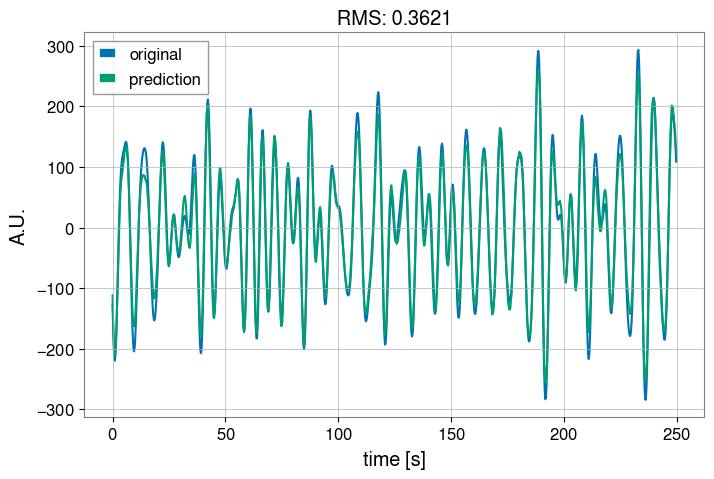

In [14]:
plt.plot(np.arange(0,1000/4.,1/4.), true[:1000], label='original')
plt.plot(np.arange(0,1000/4.,1/4.), pred[:1000], label='prediction')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((pred-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('A.U.')
plt.legend()

### Plot: results (reverse the normalization)

In [15]:
utils = np.load('data/utils_{}.npz'.format(time))
mean = utils['mean']
std = utils['std']

# convert back to unit of target
pred *= std[9].ravel()
pred += mean[9].ravel()

true = true*std[9].ravel() 
true += mean[9].ravel()

FileNotFoundError: [Errno 2] No such file or directory: 'data/utils_1381528818.npz'

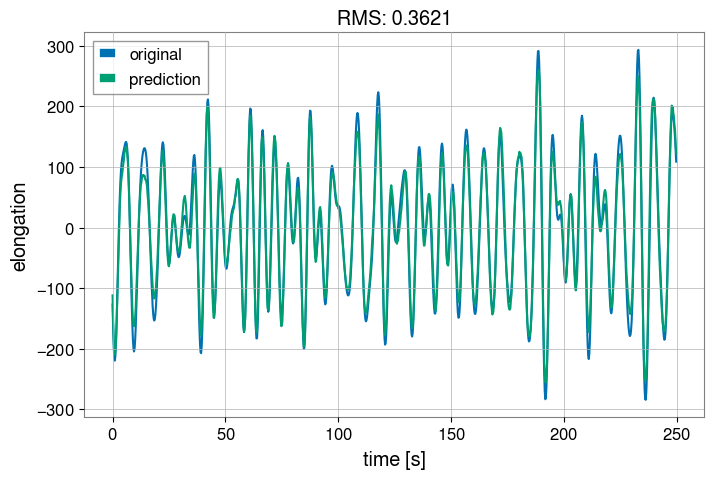

In [16]:
plt.plot(np.arange(0,1000/4.,1/4.), true[:1000], label='original')
plt.plot(np.arange(0,1000/4.,1/4.), pred[:1000], label='prediction')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((pred-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('elongation')
plt.legend()

### Plot: results (reverse the normalization, with bandpass to 0.1-0.3 Hz)

In [17]:
strain_pred = TimeSeries(pred, dt=1/4.)
#strain_pred_bp = strain_pred.bandpass(0.1, 0.3)
strain_pred_bp = strain_pred

In [18]:
strain_org = TimeSeries(true, dt=1/4.)

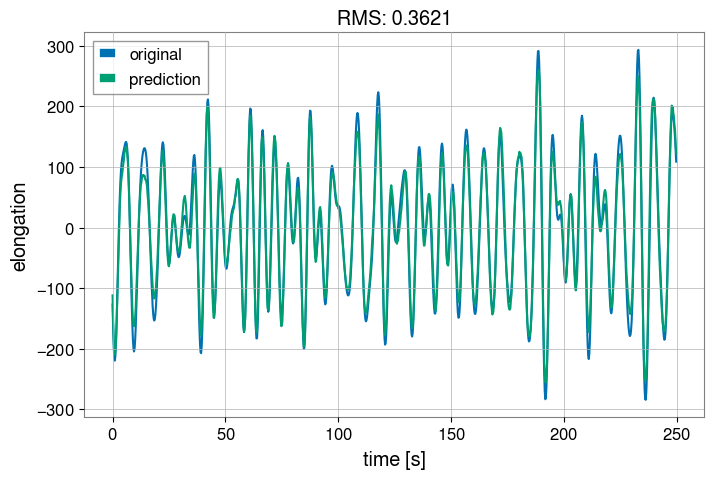

In [19]:
plt.plot(np.arange(0,1000/4.,1/4.), true[:1000], label='original')
plt.plot(np.arange(0,1000/4.,1/4.), strain_pred_bp.value[:1000], label='prediction')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((strain_pred_bp.value-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('elongation')
plt.legend()

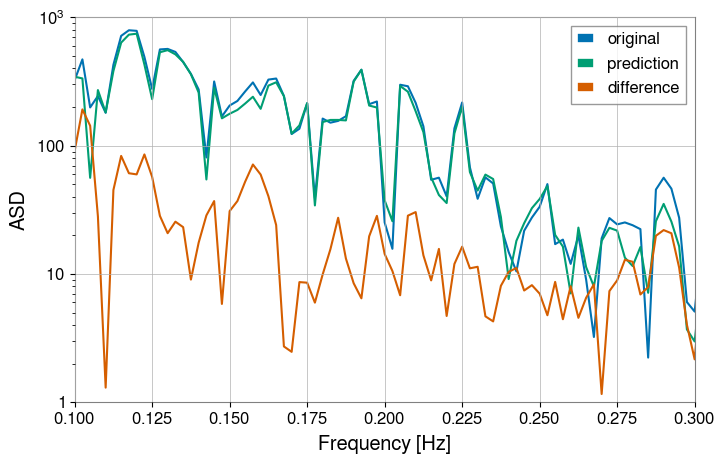

In [20]:
ASD_org = strain_org.asd(fftlength=400,overlap=0.1,method='median')
ASD_pred_bp = strain_pred_bp.asd(fftlength=400,overlap=0.1,method='median')
ASD_diff_bp = (strain_pred_bp-strain_org).asd(fftlength=400,overlap=0.1,method='median')

#plt.loglog(ASD_org, label='original')
#plt.loglog(ASD_pred_bp, label='prediction')
#plt.loglog(ASD_diff_bp, label='difference')
plt.plot(ASD_org, label='original')
plt.plot(ASD_pred_bp, label='prediction')
plt.plot(ASD_diff_bp, label='difference')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.xlim([0.1,0.3])
plt.ylim([1, 10**3])
plt.yscale('log')
plt.legend()